In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import csv
import matplotlib.dates as mdates
import pyreadr as pyr
import os

In [2]:
obs = pd.read_excel("observed.xlsx")
obs["obs"] = pd.to_datetime(obs["obs"], format="%Y-%m-%d")
obs

,sites,fish ID,obs
0,NECHAKO RIVER AT VANDERHOOF,4,2022-08-27
1,NECHAKO RIVER AT VANDERHOOF,5,2022-08-27
2,NECHAKO RIVER AT VANDERHOOF,10,2022-08-28


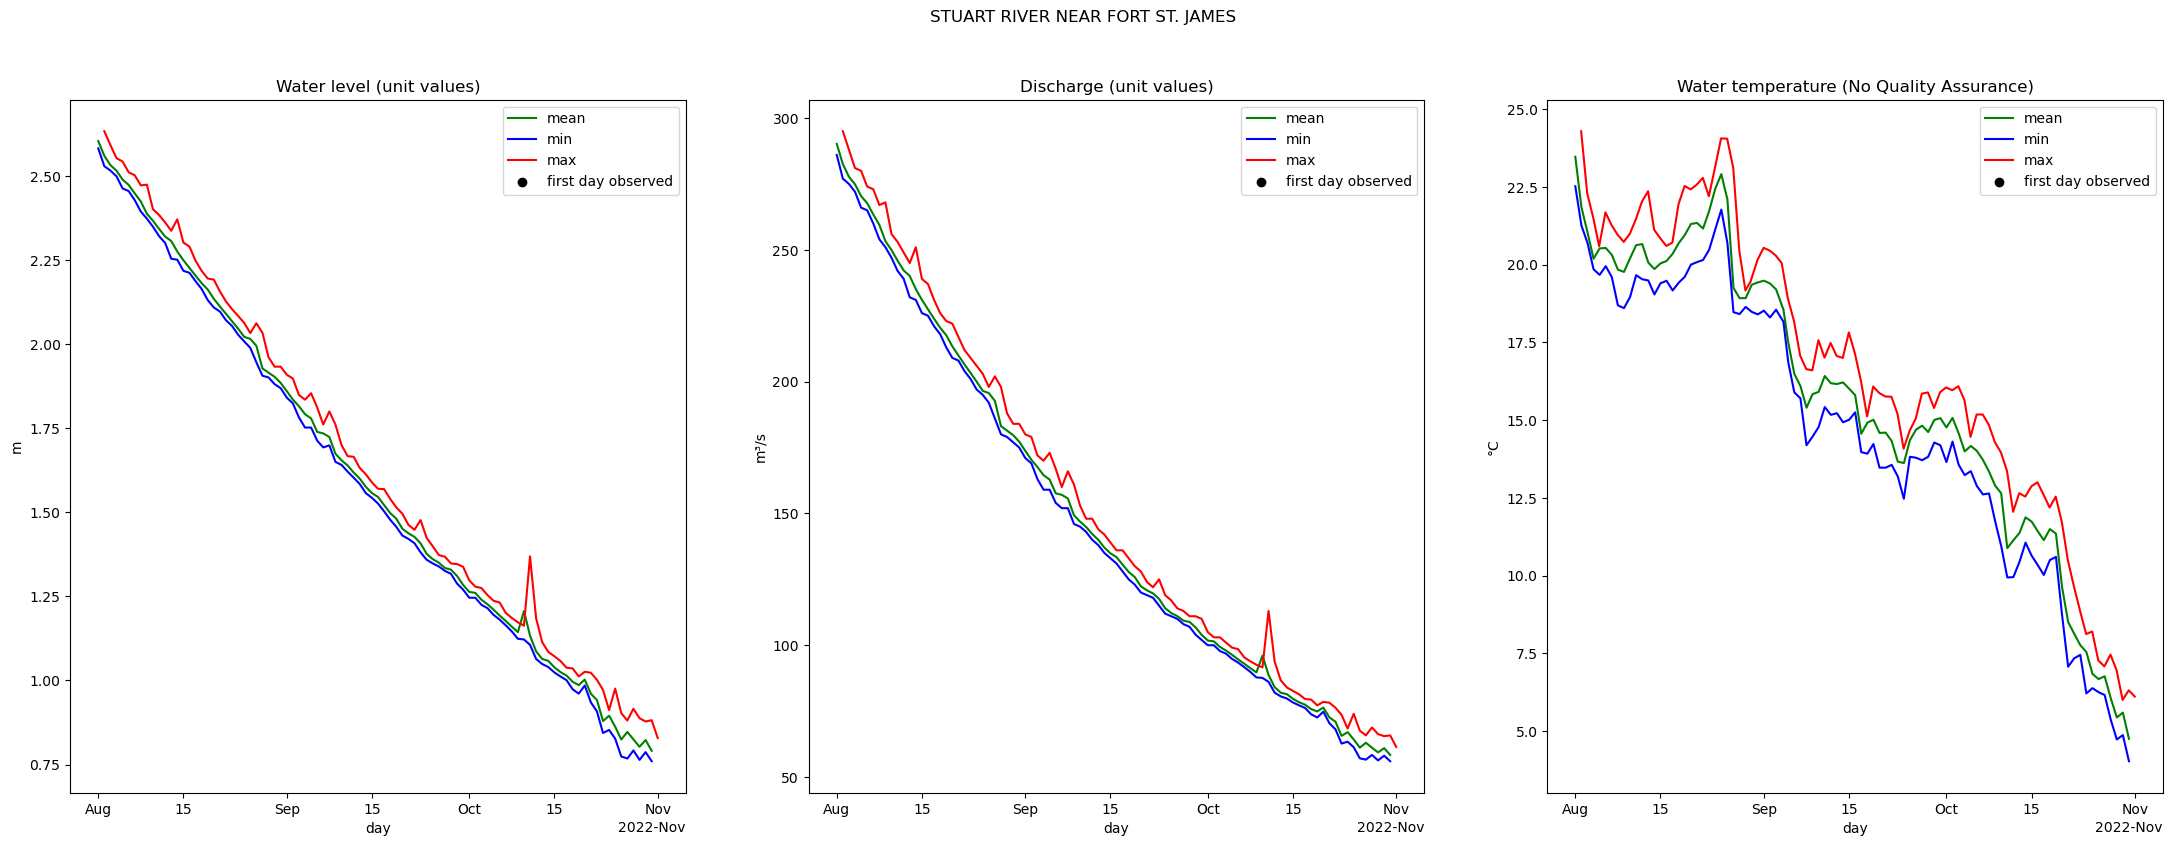

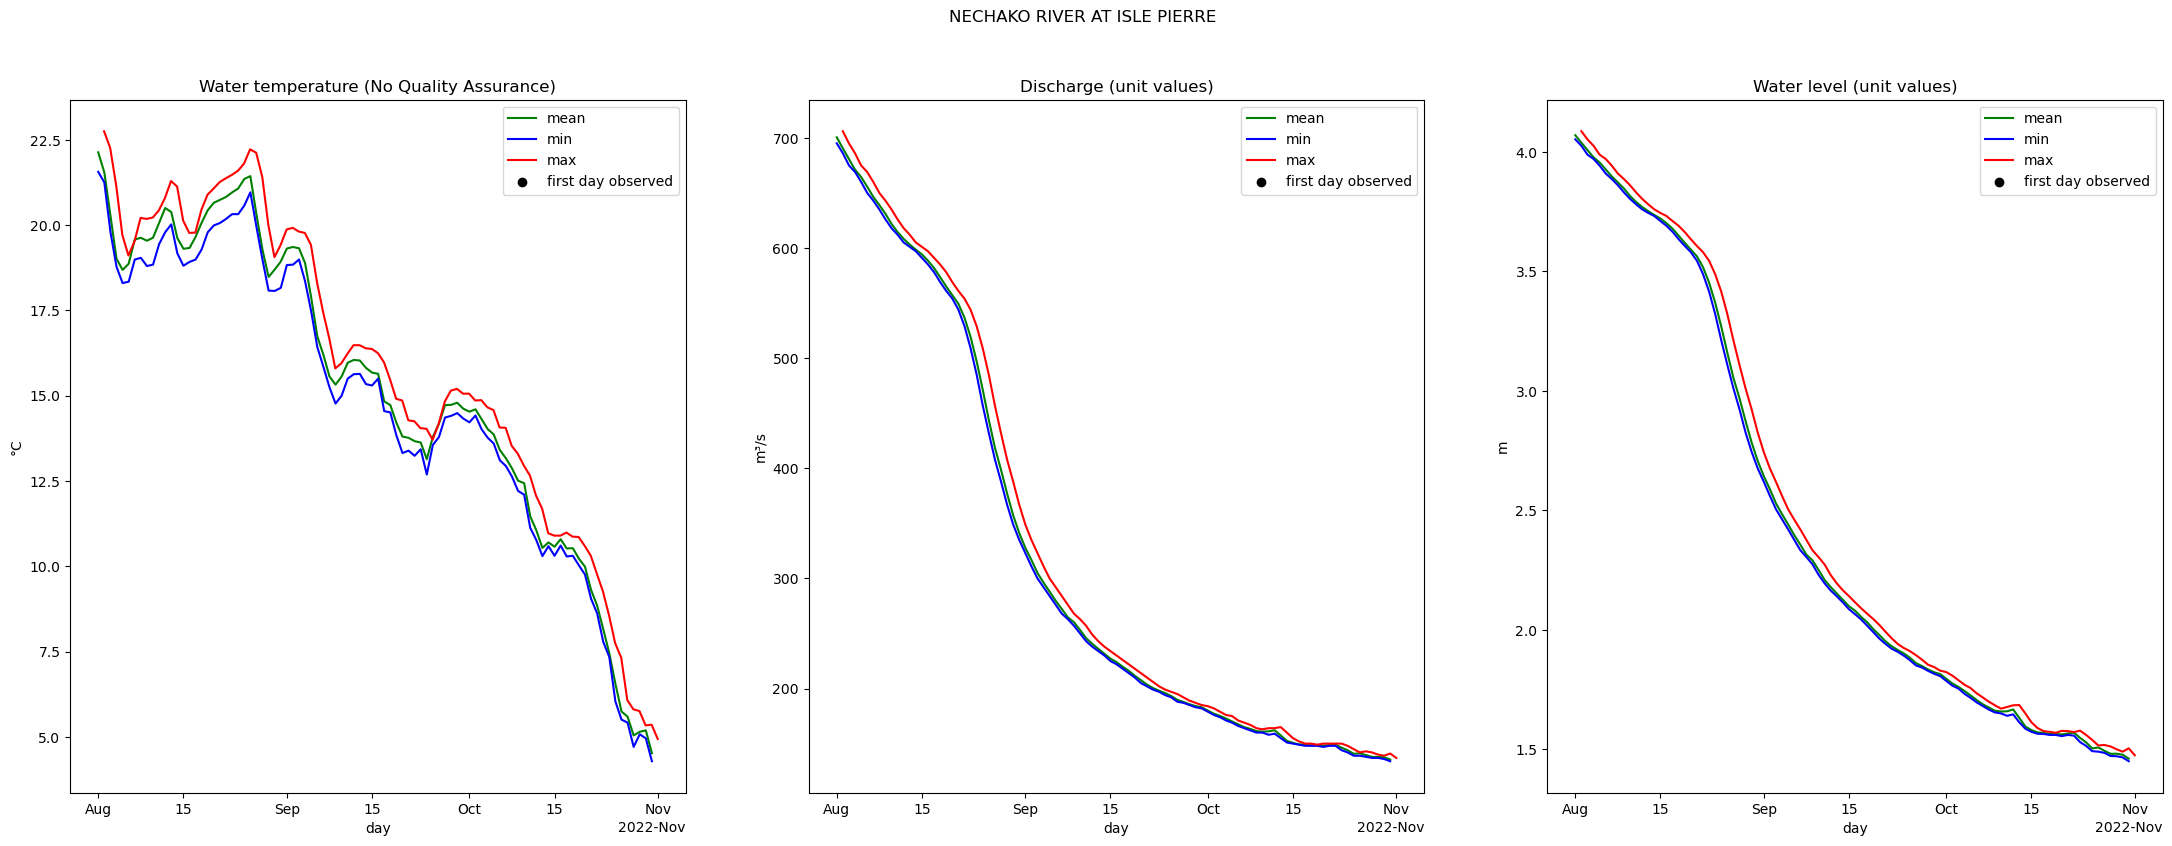

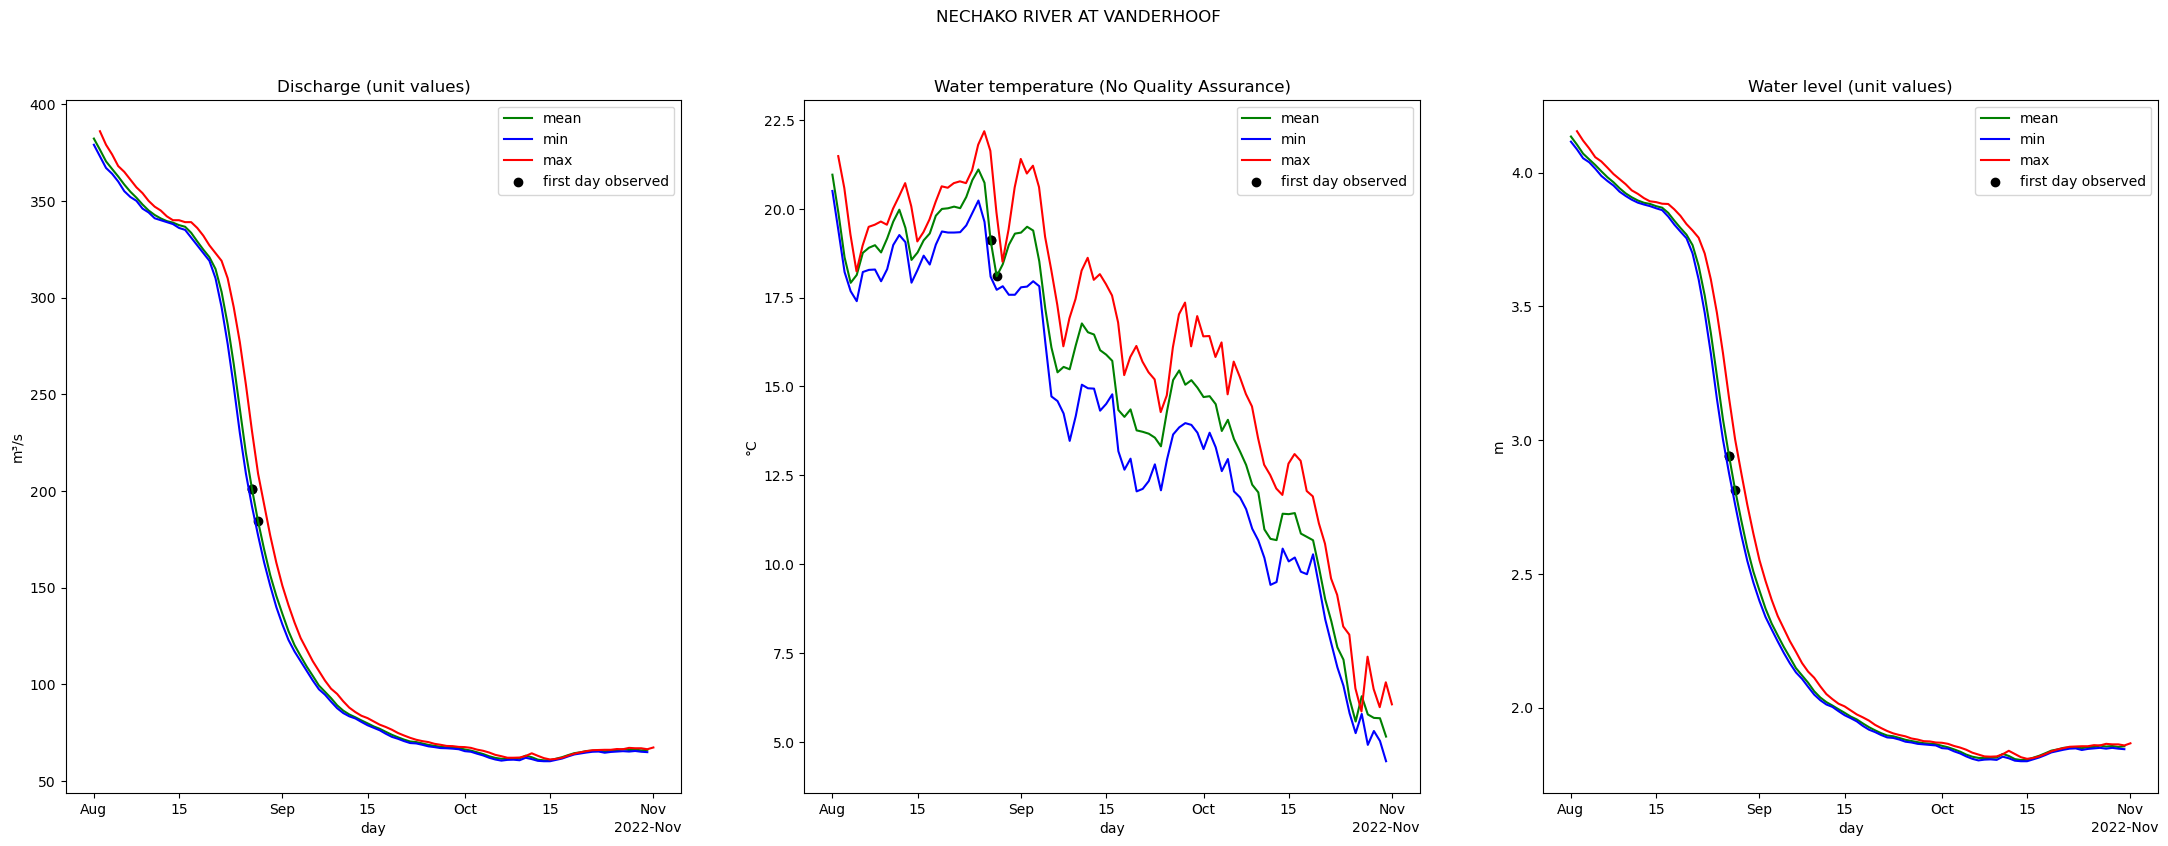

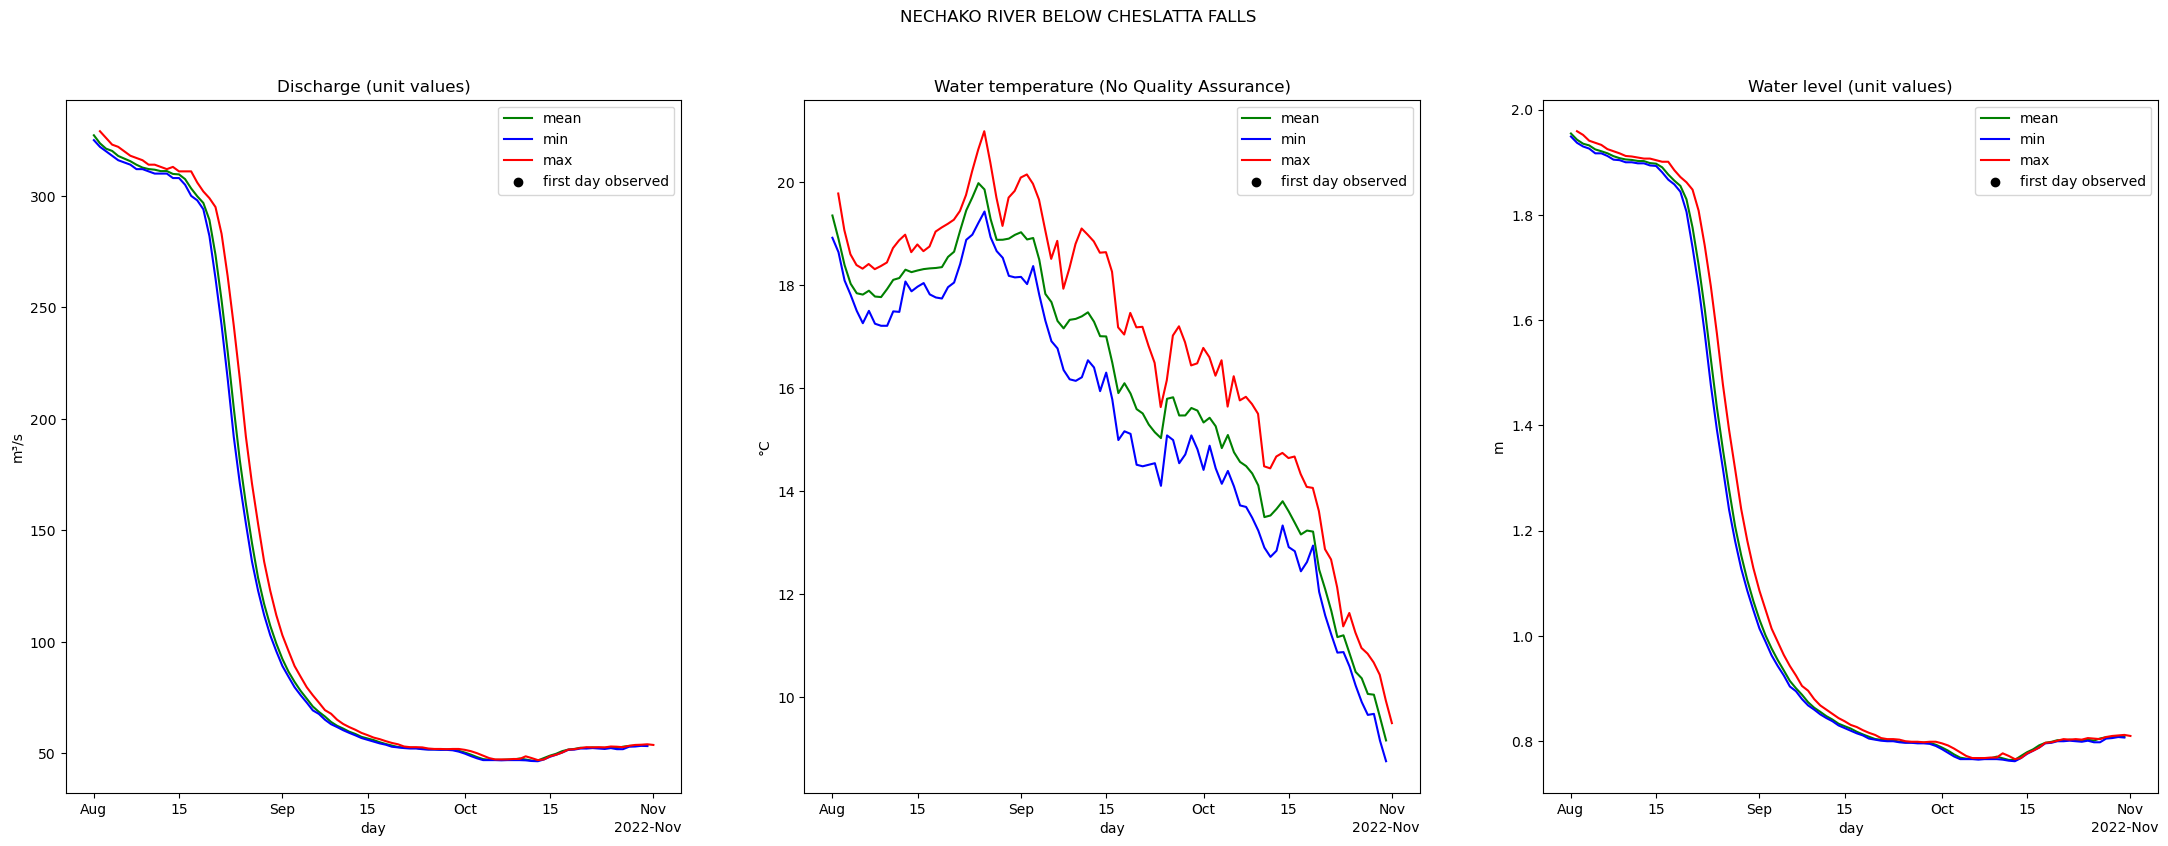

In [3]:

folders = glob("waters data/*")
for folder in folders:
    csv_files = glob(f'{folder}/*.csv')
    title = folder.split("-")[1].strip()
    plt.figure(figsize=(27, 9), facecolor="white")
    plt.suptitle(title)
    j = 0
    observed = obs.loc[obs["sites "] == title, :]
    for csv_file in csv_files:
        j += 1
        plt.subplot(1, len(csv_files), j)
        csvfile = open(csv_file, 'r')
        i = 0
        for row in csv.reader(csvfile, delimiter = ','):
            i += 1
            if i == 8:
                title, unit = row[1:]
                break
        plt.title(title)
        plt.ylabel(unit)
        plt.xlabel("day")
        csv_data = pd.read_csv(csv_file, delimiter=",", skiprows=8).iloc[:, [0, 2]]
        cols = csv_data.columns
        columns = csv_data.columns.difference([cols[0]])
        csv_data[columns] = csv_data[columns].astype(float)
        csv_data[cols[0]] = pd.to_datetime(csv_data[cols[0]], format="%Y-%m-%d %H:%M:%S")
        csv_data = csv_data.resample('d', on=cols[0])
        mean_dict = {                                                                                                             
            cols[0]: 'first',                                                                                                    
            cols[1]: 'mean',
        }
        means = csv_data.apply(mean_dict)
        mins = csv_data.min()
        maxs = csv_data.max()
        observed = observed.merge(means, "inner", right_index=True, left_on = "obs")
        plt.plot(*means.to_numpy().T, color = "green", label = "mean")
        plt.plot(*mins.to_numpy().T, color = "blue", label = "min")
        plt.plot(*maxs.to_numpy().T, color = "red", label = "max")
        plt.scatter(observed["obs"], observed[cols[1]], color = "k", label = "first day observed")
        ax = plt.gca()
        locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        plt.legend()
    plt.savefig(f"{folder}/fig.jpeg");

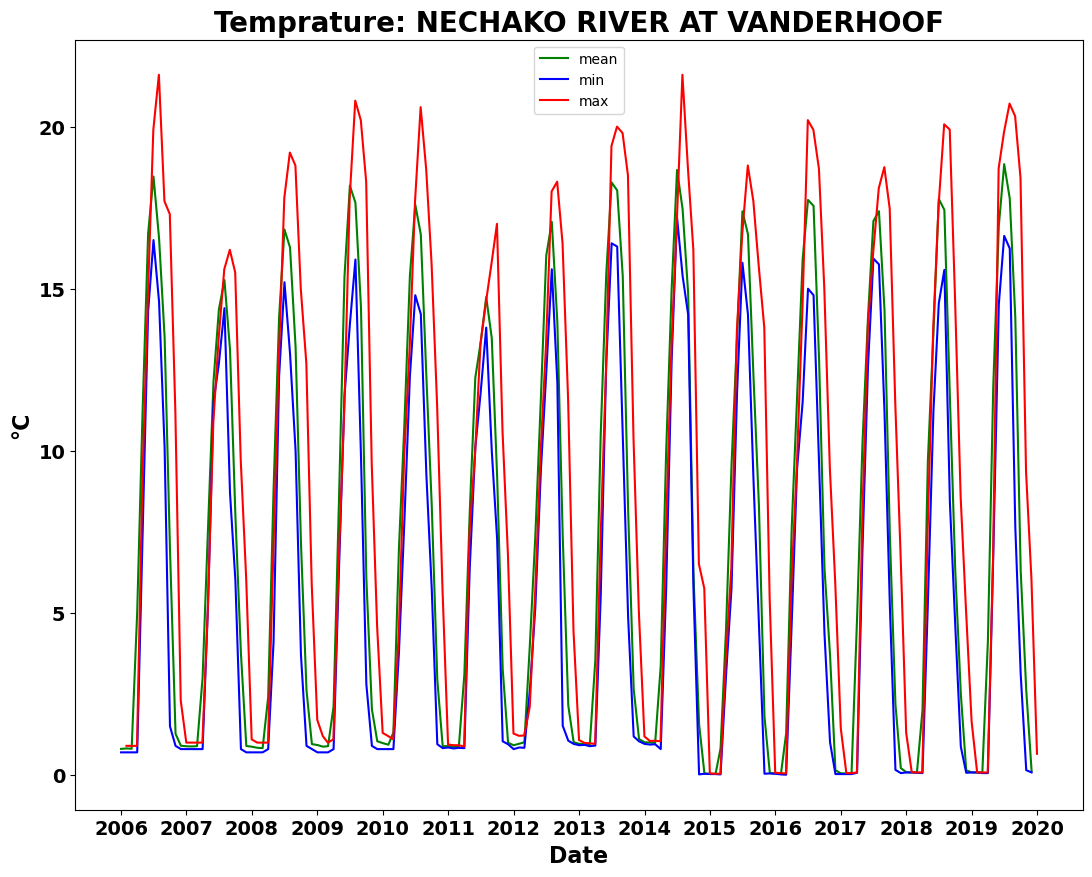

In [4]:
result = pyr.read_r('Vanderhoof_station_data_2006_2019.Rdata')
vanderhoof_t = result['Temperature']
vanderhoof_t.drop(columns = ['Station'], inplace = True)
vanderhoof_t = vanderhoof_t.iloc[:, ::-1]
vanderhoof_t.columns = cols
columns = vanderhoof_t.columns.difference([cols[0]])

vanderhoof_t[columns] = vanderhoof_t[columns].astype(float)
vanderhoof_t[cols[0]] = pd.to_datetime(vanderhoof_t[cols[0]], format="%Y-%m-%d %H:%M:%S")
vanderhoof_t = vanderhoof_t.resample('m', on=cols[0])
vanderhoof_t
mean_dict = {                                                                                                             
    cols[0]: 'first',                                                                                                    
    cols[1]: 'mean',
}
vanderhoof_mean = vanderhoof_t.apply(mean_dict)
vanderhoof_min = vanderhoof_t.min()
vanderhoof_max = vanderhoof_t.max()
# date = vanderhoof_mean.iloc[:, 0].apply(lambda x: x.strftime('%Y-%m'))
# vanderhoof_mean.iloc[:, 0] = vanderhoof_mean.iloc[:, 0].dt.to_period("M")
# vanderhoof_min.iloc[:, 0] = vanderhoof_min.iloc[:, 0].dt.to_period("M")
# vanderhoof_max.iloc[:, 0] = vanderhoof_max.iloc[:, 0].dt.to_period("M")
plt.figure(figsize=(13, 10), facecolor="white")
plt.plot(*vanderhoof_mean.to_numpy().T, color = "green", label = "mean")
plt.plot(*vanderhoof_min.to_numpy().T, color = "blue", label = "min")
plt.plot(*vanderhoof_max.to_numpy().T, color = "red", label = "max")
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=13, maxticks=28)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.title('Temprature: NECHAKO RIVER AT VANDERHOOF', fontsize=20, weight='bold')  # Title
plt.xlabel('Date', fontsize=16, weight='bold')  # X label
plt.ylabel('°C', fontsize=16, weight='bold')  # Y label
plt.xticks(fontsize=14, weight='bold')  # X ticks
plt.yticks(fontsize=14, weight='bold')  # Y ticks
plt.legend();

if not os.path.exists('./pics/temperature'):
    os.mkdir('./pics/temperature')
plt.savefig('./pics/temperature/vanderhoof.jpg')

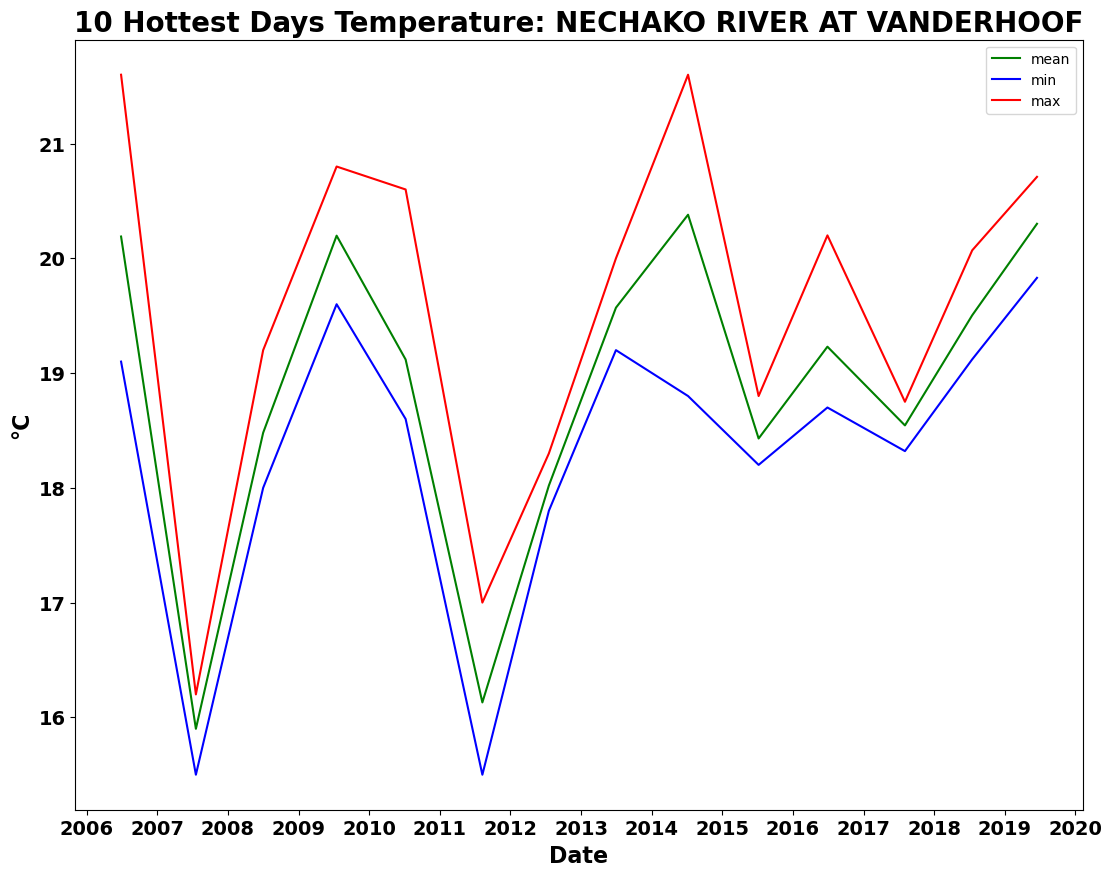

In [5]:
result = pyr.read_r('Vanderhoof_station_data_2006_2019.Rdata')
vanderhoof_t = result['Temperature']
vanderhoof_t.drop(columns = ['Station'], inplace = True)
vanderhoof_t = vanderhoof_t.iloc[:, ::-1]
vanderhoof_t.columns = cols
columns = vanderhoof_t.columns.difference([cols[0]])

vanderhoof_t[columns] = vanderhoof_t[columns].astype(float)
vanderhoof_t[cols[0]] = pd.to_datetime(vanderhoof_t[cols[0]], format="%Y-%m-%d %H:%M:%S")
vanderhoof_t['year'] = vanderhoof_t['Date (PST)'].dt.year

hottest_days = vanderhoof_t.groupby('year').apply(lambda x: x.nlargest(10, 'Value(m)'))
hottest_days = hottest_days.drop(columns=['year']).reset_index()
hottest_days.drop(columns='level_1', inplace=True)
hottest_days['year'] = hottest_days['Date (PST)'].dt.year
hottest_days = hottest_days.groupby('year')

date = hottest_days.min()['Date (PST)']

plt.figure(figsize=(13, 10), facecolor="white")
plt.plot(date, hottest_days.mean()['Value(m)'], color = "green", label = "mean")
plt.plot(date, hottest_days.min()['Value(m)'], color = "blue", label = "min")
plt.plot(date, hottest_days.max()['Value(m)'], color = "red", label = "max")
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=13, maxticks=28)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.title('10 Hottest Days Temperature: NECHAKO RIVER AT VANDERHOOF', fontsize=20, weight='bold')  # Title
plt.xlabel('Date', fontsize=16, weight='bold')  # X label
plt.ylabel('°C', fontsize=16, weight='bold')  # Y label
plt.xticks(fontsize=14, weight='bold')  # X ticks
plt.yticks(fontsize=14, weight='bold')  # Y ticks
plt.legend();

if not os.path.exists('./pics/temperature'):
    os.mkdir('./pics/temperature')
plt.savefig('./pics/temperature/vanderhoof_10hottestDays.jpg')